Using data from Ives et al. "Single Channel Probe Utilizing the EGN Model to Estimate Link Parameters for Network Abstraction"  
Demonstrate the idea of using the physical model to compensate for areas where we dont have much data, which could be because of data acquisition causing a bottleneck (so data is collected where we expect large variations) or just due to missing data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from simple_model import simple_model

font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/physical_gps/david_data/'
snr = np.genfromtxt(open(str(data_dir) + "snr_david.csv", "r"), delimiter=",", dtype =float)
pch = np.genfromtxt(open(str(data_dir) + "power_david.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [3]:
# snr = snr[:16] # -10 to 5 dBm
# pch = pch[:16] 
snr_comp = snr[:16] # to compare with SSFM
pch_comp = pch[:16] 
# snr = snr[1:14]  # -8 to 4 dBm
# pch = pch[1:14]  
# snr = snr[3:10] # -6 to 0 dBm  # 3 dBm around peak 
# pch = pch[3:10] 
snr = snr[1:15] # -9 to 4 dBm  # 2 dB SNR penalty around the peak 
pch = pch[1:15] 

In [4]:
down_sample_factor = 1
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [5]:
len(pch)

14

In [6]:
pch[0]

4.0

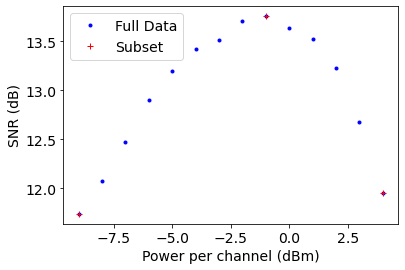

In [8]:
# inds = [0, 4, 8, 12, 15]  # for -10 to 5 dBm
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
# inds = [0, 3, 6, 9, 12]  # for -8 to 4 dBm
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
# inds = [0, 7, 14, -1]  # for -15 to 5 dBm
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]]])
# inds = [0, 3, -1]  # -6 to 0 dBm, three measurements 
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]]])
# inds = [0, 2, 4, -1]  # -6 to 0 dBm, four measurements 
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]]])
# inds = [0, 2, 3, 4, -1]  # -6 to 0 dBm, five measurements 
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
#   # -6 to 0 dBm, seven measurements 
# snr_sub = np.copy(snr)
# pch_sub = np.copy(pch)
# inds = [0, 3, 6, 9, -1]  # for -9 to 4 dBm, five meas.
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]], snr[inds[4]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]], pch[inds[4]]])
# inds = [0, 4, 8, -1]  # for -9 to 4 dBm, four meas.
# snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]], snr[inds[3]]])
# pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]], pch[inds[3]]])
inds = [0, 5, -1]  # for -9 to 4 dBm, three meas.
snr_sub = np.array([snr[inds[0]], snr[inds[1]], snr[inds[2]]])
pch_sub = np.array([pch[inds[0]], pch[inds[1]], pch[inds[2]]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans, TRx back to back SNR mean [dB],  TRx back to back SNR standard dev. [dB], random seed

In [9]:
pch[5]

-1.0

In [10]:
# def gen_phys_targets(model, pch, num_pts_phys):
#     pch_gn = np.linspace(pch[0], pch[-1], num_pts_phys)
#     snr_phys = (model.predict_snr(pch_gn)).reshape(-1,1)
#     return pch_gn, snr_phys
def train_phys_gp(pch, pch_phys, snr, snr_phys, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-8, 1e5)) +  W(1, (1e-5,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_pred, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys
def train_standard_gp(pch, snr, pch_pred):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    snr = snr.reshape(-1,1)
    pch_pred = pch_pred.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-8,1e5))
    gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr.fit(pch, snr)
    mu_sk, std_sk = gpr.predict(pch_pred, return_std=True)
    std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
    theta = gpr.kernel_.theta
    lml = gpr.log_marginal_likelihood()
    return mu_sk, std_sk, theta, lml
def convert_to_lin(x):
    return 10**(x/10)
def convert_to_db(x):
    return 10*np.log10(x)
def convert_to_dbm(x):
    return 10*np.log10(x/1e-3)
def convert_to_lin_dbm(x):
    return 1e-3*convert_to_lin(x)
def snr_simple_gen(p_in, a, b, rseed, sig):
        np.random.seed(rseed)
        p_in = p_in + np.random.normal(0, sig, len(p_in))
        p_in = convert_to_lin_dbm(p_in) # W
#         return convert_to_db(1/( (a*p_in**(-1) + b*p_in**2) + 1/29.2  ))
        return convert_to_db(1/( (a*p_in**(-1) + b*p_in**2) + 1/convert_to_lin(14.8)  ))

David's paper: SNR$^{-1}$ = SNR$^{-1}$ + $\mathrm{{SNR}_0}^{-1}$  
$\mathrm{{SNR}_0}=29.2=14.7$dB  
New model: 1/SNR$_{phys}$ = 1/SNR + N(-14.7, 0.01$\times$-14.7)

IDEA: Fit simple model to the SSFM results with initial guesses.

In [54]:
def apply_b2b(snr, b2b):
    return convert_to_db(1/(1/convert_to_lin(snr) + 1/convert_to_lin(b2b)))
# snr_ssfm = [15.77, 17.71, 19.49, 20.76, 20.64, 18.54, 15.09]  
# pch_ssfm = [ -8, -6, -4, -2, 0, 2, 4]
# snr_ssfm = [14.78, 20.94, 15.09]  
# pch_ssfm = [ -9, -1, 4]
snr_ssfm = [15.77, 20.64, 15.09]  
pch_ssfm = [ -8, 0, 4]
#snr_ssfm_m = [apply_b2b(i, convert_to_db(29.2)) for i in snr_ssfm]
snr_ssfm_m = [apply_b2b(i, convert_to_db(convert_to_lin(14.8))) for i in snr_ssfm]

In [55]:
sim_model = simple_model()

In [56]:
snr_ssfm = np.array(snr_ssfm)
pch_ssfm = np.array(pch_ssfm)
snr_ssfm_m = np.array(snr_ssfm_m)

In [57]:
opt_vals = sim_model.fit(pch_ssfm.reshape(len(pch_ssfm),), snr_ssfm.reshape(len(snr_ssfm),),
                         init_guess = np.array([1e-5, 1e3]))

In [58]:
a_opt, b_opt = opt_vals[0]
pch_sim_comp = np.linspace(pch[0], pch[-1], 30)
snr_sim = snr_simple_gen(pch_sim_comp, a_opt, b_opt, 1, 0.5/3)
print(a_opt)
print(b_opt)

4.121731562907489e-06
4537.197643412776


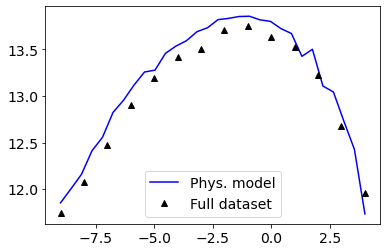

In [59]:
plt.plot(pch_sim_comp, snr_sim, 'b-', label='Phys. model')
plt.plot(pch, snr, 'k^', label='Full dataset')
#plt.plot(pch_ssfm, snr_ssfm_m, 'r*', label='SSFM')
plt.legend() 
plt.show()

In [60]:
#pch_pred_phys = np.linspace(pch[-1], pch[0], 100)
pch_pred_phys = np.copy(pch)
snr_phys_ensemble = []
for i in range(5):
    snr_phys_ensemble.append(snr_simple_gen(pch_pred_phys, a_opt, b_opt, i, 0.5/3))

In [61]:
snr_phys_ensemble_ave = np.mean(snr_phys_ensemble, axis=0)

Physical model peak prediction (to nearest 1 dBm)

In [62]:
pch[np.argmax(snr_simple_gen(pch, a_opt, b_opt, i, 1e-3))]

-1.0

In [63]:
snr[np.argmax(snr_simple_gen(pch, a_opt, b_opt, i, 1e-3))]

13.7537823867491

In [64]:
snr[np.argmax(snr_simple_gen(pch, a_opt, b_opt, i, 1e-3))] - snr[1]

1.074446161744799

In [65]:
pch[1]

3.0

In [66]:
snr[np.argmax(snr_simple_gen(pch, a_opt, b_opt, i, 1e-3))] - snr[-2]

1.674524281951399

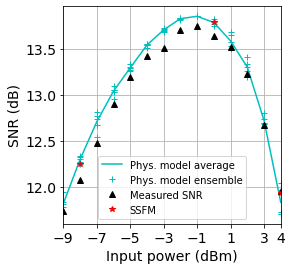

In [69]:
f, ax = plt.subplots()
plt.plot(pch_pred_phys, snr_phys_ensemble_ave, 'c-', label='Phys. model average')
plt.plot(pch_pred_phys, snr_phys_ensemble[0], 'c+', label='Phys. model ensemble')
plt.plot(pch_pred_phys, snr_phys_ensemble[1], 'c+')
plt.plot(pch_pred_phys, snr_phys_ensemble[2], 'c+')
plt.plot(pch_pred_phys, snr_phys_ensemble[3], 'c+')
plt.plot(pch_pred_phys, snr_phys_ensemble[4], 'c+')
plt.plot(pch, snr, 'k^', label='Measured SNR')
plt.plot(pch_ssfm, snr_ssfm_m, 'r*', label='SSFM')
plt.xlim([pch[-1], pch[0]])
#plt.xticks([-8, -6, -4, -2, 0, 2, 4])
plt.xticks([-9, -7, -5, -3, -1, 1, 3, 4])
#plt.ylim([13, 14])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
plt.savefig('figures/SSFM_phys_model_meas_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

Compute model error w.r.t. full dataset:

In [70]:
mse_phys_model = np.mean(((snr - snr_phys_ensemble_ave)**2)**0.5)
mse_phys_model

0.12669188342722038

In [71]:
num_pts_phys = 15

In [72]:
pch_gn_david = np.linspace(pch[0], pch[-1], num_pts_phys)
snr_gn_david = snr_simple_gen(pch_gn_david, a_opt, b_opt, 1, 0.5/3)

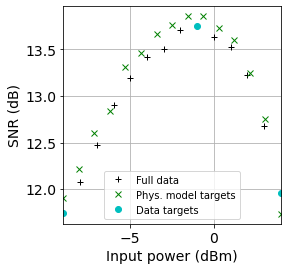

In [73]:
f, ax = plt.subplots()
plt.plot(pch, snr, 'k+', label='Full data')
plt.plot(pch_gn_david, snr_gn_david, 'gx', label='Phys. model targets')
plt.plot(pch_sub, snr_sub, 'co', label='Data targets')
plt.xlim([pch[-1], pch[0]])
#plt.yticks([10,10.5,11,11.5,12, 12.5, 13, 13.5])
#plt.ylim([12, 13.6])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
plt.legend(prop={'size':10})
plt.grid()
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

Plot the physical model against measured data.

In [74]:
pch_test = np.copy(pch_gn_david).reshape(-1,1)
snr_phys_test = np.copy(snr_gn_david).reshape(-1,1)
#pch_pred = np.linspace(pch[0], pch[-1], 100)
pch_pred = np.arange(pch[-1], pch[0]+0.1, 0.1)

In [75]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_sub, pch_test, snr_sub, snr_phys_test, pch_pred)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [76]:
mu_sk, std_sk, theta, lml = train_standard_gp(pch_sub, snr_sub, pch_pred)
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

In [77]:
mu_sk_f, std_sk_f, theta_f, lml_f = train_standard_gp(pch, snr, pch_pred)
mu_sk_p2_f = mu_sk_f + 2*std_sk_f 
mu_sk_n2_f = mu_sk_f - 2*std_sk_f 

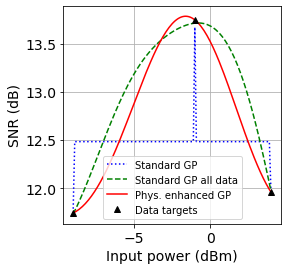

In [78]:
f, ax = plt.subplots()
ax.plot(pch_pred, mu_sk, 'b:', label = 'Standard GP')
ax.plot(pch_pred, mu_sk_f, 'g--', label = 'Standard GP all data')
ax.plot(pch_pred, mu_sk_phys, 'r-', label = 'Phys. enhanced GP')
#ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
#ax.plot(pch_shifted, snr,'k+', label='Full data set')
#plt.xlim([pch[0]-0.05, pch[-1]+0.05])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Predictive mean comparison")
plt.legend(prop={'size':10})
plt.grid()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/david_pred_mean_comp_ppert.pdf', dpi=200,bbox_inches='tight')
plt.show()

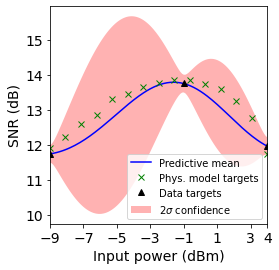

In [80]:
f, ax = plt.subplots()
ax.plot(pch_pred, mu_sk_phys, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_test, snr_phys_test, 'gx', label = 'Phys. model targets')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
#ax.plot(pch_shifted, phys_model_snr_plt, 'k:', label = 'Phys. model')
ax.fill(np.concatenate([pch_pred, pch_pred[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch[-1], pch[0]])
#plt.xlim([-8, 4])
#plt.ylim([11.5, 14.2])
#plt.xticks([-8, -6, -4, -2, 0, 2, 4])
plt.xticks([-9, -7, -5, -3, -1, 1, 3, 4])
#plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Physics-enhanced GP")
plt.legend(prop={'size':10}, loc=4)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.grid()
#plt.savefig('figures/david_comp_gn_enhanced_gp_ppert.pdf', dpi=200,bbox_inches='tight')
#plt.savefig('figures/final_phys_gp_comp.pdf', dpi=200,bbox_inches='tight')
plt.savefig('figures/SSFM_phys_gp_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

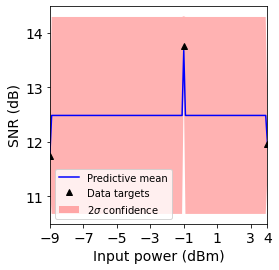

In [81]:
f, ax = plt.subplots()
ax.plot(pch_pred, mu_sk, 'b-', label = 'Predictive mean')
#ax.plot(pch_shifted, snr,'k+', label = 'All data')
ax.plot(pch_sub, snr_sub,'k^', label = 'Data targets')
ax.fill(np.concatenate([pch_pred, pch_pred[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch[-1], pch[0]])
#plt.xticks([-8, -6, -4, -2, 0, 2, 4])
#plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5 ])
plt.xticks([-9, -7, -5, -3, -1, 1, 3, 4])
#plt.ylim([11.3,14.5])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(loc= 3,prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
#plt.savefig('figures/david_comp_standard_gp_ppert.pdf', dpi=200,bbox_inches='tight')
plt.savefig('figures/final_stan_gp_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [72]:
#GN_pred_mean = np.genfromtxt(open("shared_data/GN_mu_sk_phys_initbtb.csv", "r"), delimiter=",", dtype =float)

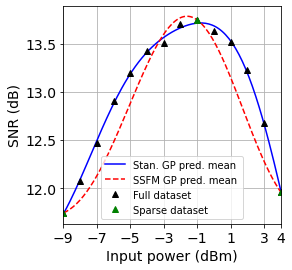

In [82]:
f, ax = plt.subplots()
ax.plot(pch_pred, mu_sk_f, 'b-', label = 'Stan. GP pred. mean ')
ax.plot(pch_pred, mu_sk_phys, 'r--', label = 'SSFM GP pred. mean')
#ax.plot(pch, GN_pred_mean, 'c:', label = 'GN GP pred. mean')
ax.plot(pch, snr,'k^', label = 'Full dataset')
ax.plot(pch_sub, snr_sub,'g^', label = 'Sparse dataset')
# ax.fill(np.concatenate([pch, pch[::-1]]),
#             np.concatenate([mu_sk_p2_f,
#                             (mu_sk_n2_f)[::-1]]),
#             alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.xlim([pch[-1], pch[0]])
#plt.xticks([-10, -7.5, -5, -2.5, 0, 2.5, 5 ])
#plt.xticks([-8, -6, -4, -2, 0, 2, 4])
plt.xticks([-9, -7, -5, -3, -1, 1, 3, 4])
#plt.ylim([11.8,14])
#plt.xticks([-2.5, -1, 0.5, 2, 3.5 ])
#plt.xticks([-6, -4, -2, 0, 2, 4 ])
plt.xlabel("Input power (dBm)")
plt.ylabel("SNR (dB)")
#plt.title("Normal GP")
plt.legend(prop={'size':10})
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.grid()
#plt.savefig('figures/david_comp_standard_gp_full_ppert.pdf', dpi=200,bbox_inches='tight')
plt.savefig('figures/final_comp_stan_gp_full.pdf', dpi=200,bbox_inches='tight')
plt.show()

Compare MSE w.r.t. data for the physical model enhanced GP trained on subset of the data and standard GP trained on full dataset.

Make predictions only at data points to compute MSE

In [83]:
gp_phys_pred, gp_phys_pred_std, _, _ = train_phys_gp(pch_sub, pch_test, snr_sub, snr_phys_test, pch)
gp_pred_f, gp_pred_std_f, _, _ = train_standard_gp(pch, snr, pch)
gp_pred, gp_pred_std, _, _ = train_standard_gp(pch_sub, snr_sub, pch)

/Users/joshnevin/sklearnforked/scikit-learn/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [84]:
mse_phys = np.mean(((snr - gp_phys_pred)**2)**0.5)

In [85]:
mse_stan_f = np.mean(((snr - gp_pred_f)**2)**0.5)

In [86]:
100*(mse_phys - mse_stan_f)/mse_stan_f

7.827277587572635

MSE difference in dB - way below 0.1 dB, which is the smallest level people care about in power budgets.

In [87]:
mse_phys - mse_stan_f

0.057930623463885

Relative change in the predictive std (%):

In [88]:
100*(np.mean(gp_phys_pred_std) - np.mean(gp_pred_std_f))/np.mean(gp_pred_std_f)

1259.8385326144894

RMSD of the predictive mean of the model with and without physical models:

In [51]:
np.mean(((mu_sk_f - mu_sk_phys)**2)**0.5)

0.23480376540446576

Mean relative difference (%):

In [258]:
np.mean(100*(mu_sk_f - mu_sk_phys)/mu_sk_f)

0.09806565859463129

In [259]:
np.exp(theta_f)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + I sigma**2 

array([2.81346999, 2.26569176, 0.07916203])

In [260]:
np.exp(theta_phys)

array([2.78329771, 1.45859718, 0.04156788])